In [1]:
from __future__ import print_function
%matplotlib inline
%config InlineBackend.figure_format = "png2x"

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

In [2]:
rcParams["savefig.dpi"] = 200
rcParams["figure.dpi"] = 200
rcParams["font.size"] = 20
rcParams["figure.figsize"] = [8, 5]
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans Serif"]
rcParams["text.usetex"] = True

# Quickstart Tutorial

Let's begin by importing the coronagraph model and checking the version number. 

In [3]:
import coronagraph as cg
print(cg.__version__)

1.01


In [4]:
cg.plot_setup.setup()

## Model Inputs

This model uses Python objects to hold all of the specific telescope/coronagraph and astrophysical parameters that we want to assume for our noise calculations. For this simple example, we'll set up the `Telescope`, `Planet`, and `Star` by instantiating them with their default values. 

In [5]:
telescope = cg.Telescope()
print(telescope)

Coronagraph: 
------------
- Telescope observing mode : IFS
- Minimum wavelength (um) : 0.3
- Maximum wavelength (um)  : 2.0
- Spectral resolution (lambda / delta-lambda)  : 70.0 
- Telescope/System temperature (K)  : 260.0 
- Detector temperature (K)  : 50.0 
- Telescope diameter (m)  : 8.0 
- Telescope emissivity  : 0.9 
- Inner Working Angle (lambda/D)  : 0.5 
- Outer Working Angle (lambda/D)  : 30000.0 
- Telescope throughput  : 0.2 
- Raw Contrast  : 1e-10 
- Dark current (s**-1)  : 0.0001 
- Horizontal pixel spread of IFS spectrum  : 3.0 
- Read noise per pixel  : 0.1 
- Maximum exposure time (hr)  : 1.0 
- Size of photometric aperture (lambda/D)  : 0.7 
- Quantum efficiency  : 0.9


In [6]:
planet = cg.Planet()
print(planet)

Planet: 
-------
- Planet name  : earth
- Stellar type of planet host star : sun
- Distance to system (pc) : 10.0
- Number of exzodis (zodis) : 1.0
- Radius of planet (Earth Radii) : 1.0
- Semi-major axis (AU) : 1.0
- Phase angle (deg) : 90.0
- Lambertian phase function : 0.3183098861837907
- Zodiacal light surface brightness (mag/arcsec**2) : 23.0
- Exozodiacal light surface brightness (mag/arcsec**2) : 22.0


In [7]:
star = cg.Star()
print(star)

Star: 
-----
- Effective Temperature (K) : 5780.0
- Radius (Solar Radii) : 1.0


In [8]:
skyflux = cg.sky_flux.SkyFlux()
print(skyflux)

Sky Flux: 
------------
- Airmass : 1.0
- PWV Mode : pwv
- Season  : 0
- Time of Night  : 0 
- Precipitable Water Vapor (PWV) [mm]  : 3.5 
- Monthly Averaged Solar Flux [sfu=0.01 MJy]  : 130.0 
- Include Scattered Moonlight?  : Y 
- Separation of Sun and Moon as seen from Earth [deg] : 90.0 
- Separation of Moon and target [deg]  : 45.0 
- Moon altitude over horizon  : 45.0 
- Moon-Earth distance (mean=1)  : 1.0 
- Include scattered starlight?  : Y 
- Include zodiacal light?  : Y 
- Heliocentric ecliptic longitude [deg]  : 135.0 
- Ecliptic latitude [deg]  : 90.0 
- Include molecular emission of lower atmosphere?  : Y 
- Include molecular emission of upper atmosphere?  : Y 
- Include upper airglow continuum?  : Y 
- Include instrumental thermal radiation?  : N 
- Instrumental temperature 1  : 0.0 
- Instrumental emmisivity 1  : 0.0 
- Instrumental temperature 2  : 0.0 
- Instrumental emmisivity 2  : 0.0 
- Instrumental temperature 3  : 0.0 
- Instrumental emmisivity 3  : 0.0 
- Calcula

Now let's load in a high resolution model Earth geometric albedo spectrum from [Robinson et al. (2011)](http://adsabs.harvard.edu/abs/2011AsBio..11..393R). This iconic spectrum is provided as part of the coronagraph model, but this step is usually project specific. 

In [8]:
# Load Earth albedo spectrum from Robinson et al. (2011)
lamhr, Ahr, fstar = cg.get_earth_reflect_spectrum()

We can take a look at the disk-integrated geomtric albedo spectrum of the Earth with realistic cloud coverage:

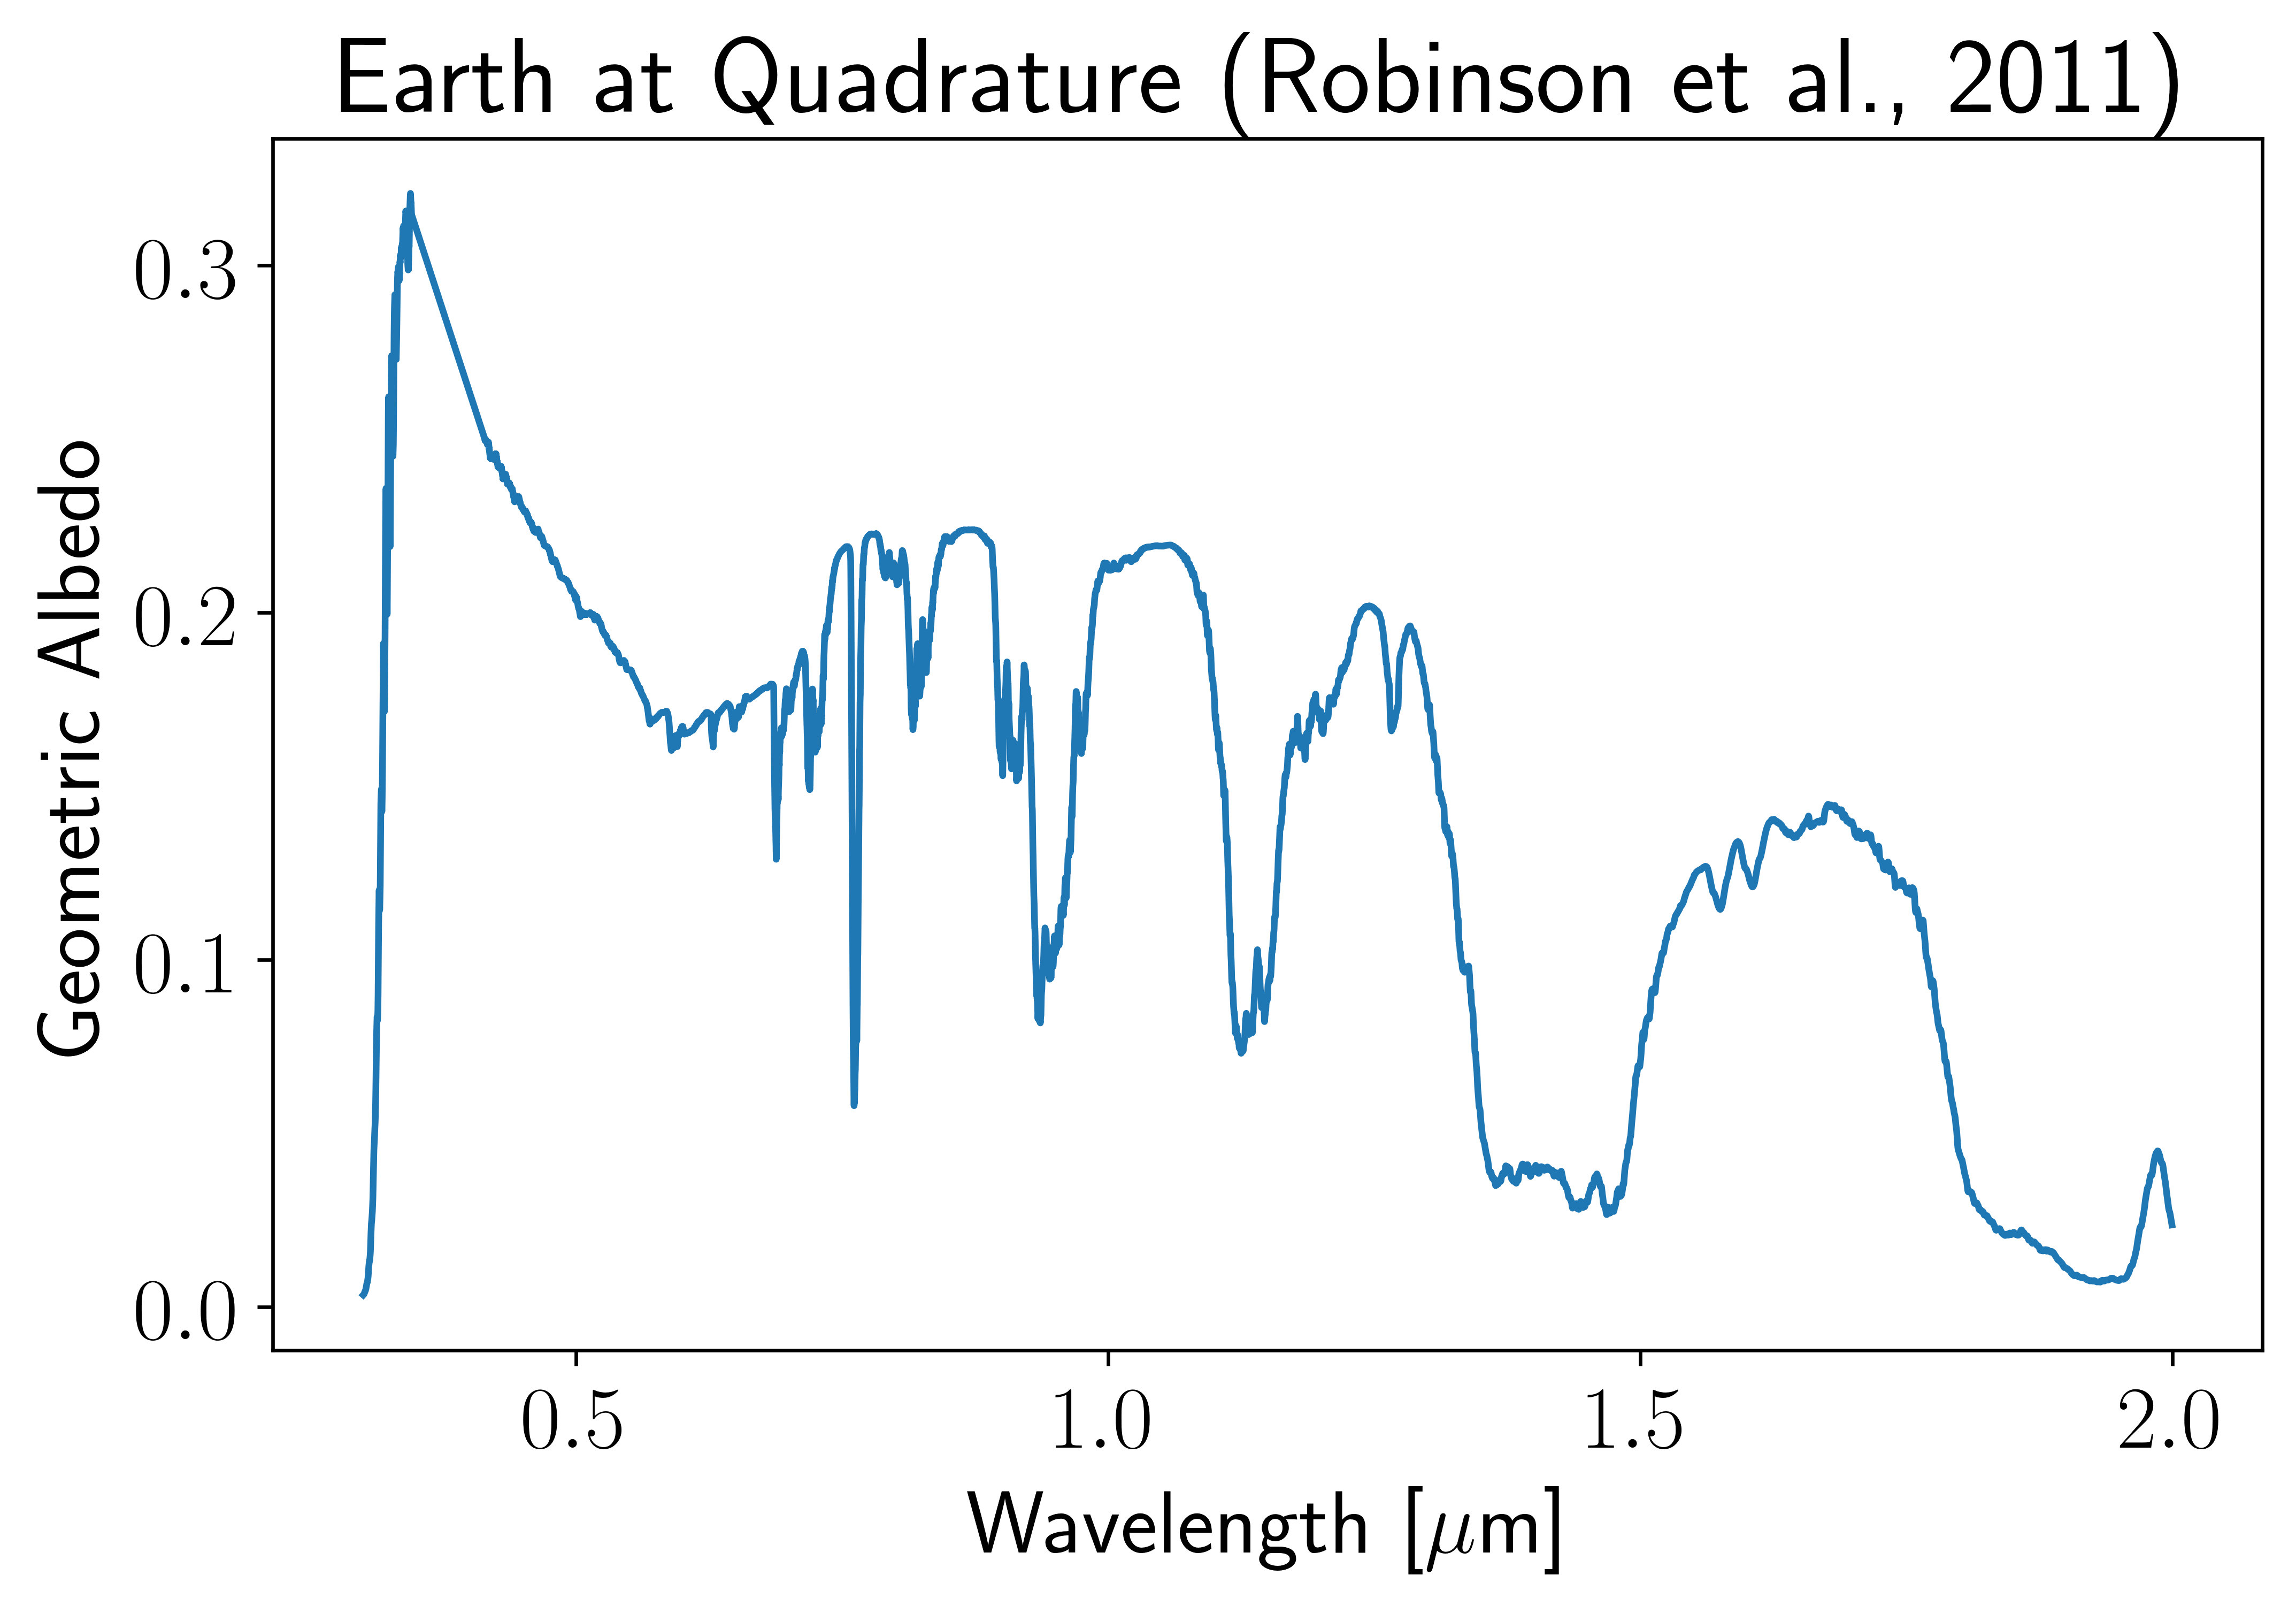

In [9]:
# Create wavelength mask
m = (lamhr > telescope.lammin) & (lamhr < telescope.lammax)

# Plot
plt.plot(lamhr[m], Ahr[m])
plt.xlabel(r"Wavelength [$\mu$m]")
plt.ylabel("Geometric Albedo")
plt.title("Earth at Quadrature (Robinson et al., 2011)");

## Running the coronagraph noise model

Now we want to calculate the photon count rates incident upon the detector due to the planet and noise sources. We can accomplish all of this with a `CoronagraphNoise` object, to which we pass our existing `telescope`, `planet`, and `star` configurations. In addition, we will set the nominal exposure time in hours, `texp`, and/or a desired signal-to-noise ratio to obtain in each spectral element, `wantsnr`. Note `texp` and `wantsnr` cannot both be satisfied simultaneously, and they can be changed at a later time without needing to recompute the photon count rates. 

In [10]:
# Define CoronagraphNoise object using our telescope, planet, and star
noise = cg.CoronagraphNoise(telescope = telescope, 
                            planet = planet, 
                            star = star, 
                            texp = 10.0, 
                            wantsnr = 10.0)

At this point we are ready to run the code to compute the desired photon count rates for our specific planetary spectrum. To do this simply call `run_count_rates` and provide the high-res planet spectrum, stellar spectrum, and wavelength grid. 

In [11]:
# Calculate the planet and noise photon count rates
noise.run_count_rates(Ahr, lamhr, fstar)

## Analyzing results

After `run_count_rates` has been run, we can access the individual wavelength-dependent noise terms as attributes of the `noise` instance of the `CoronagraphNoise` object. For example: 

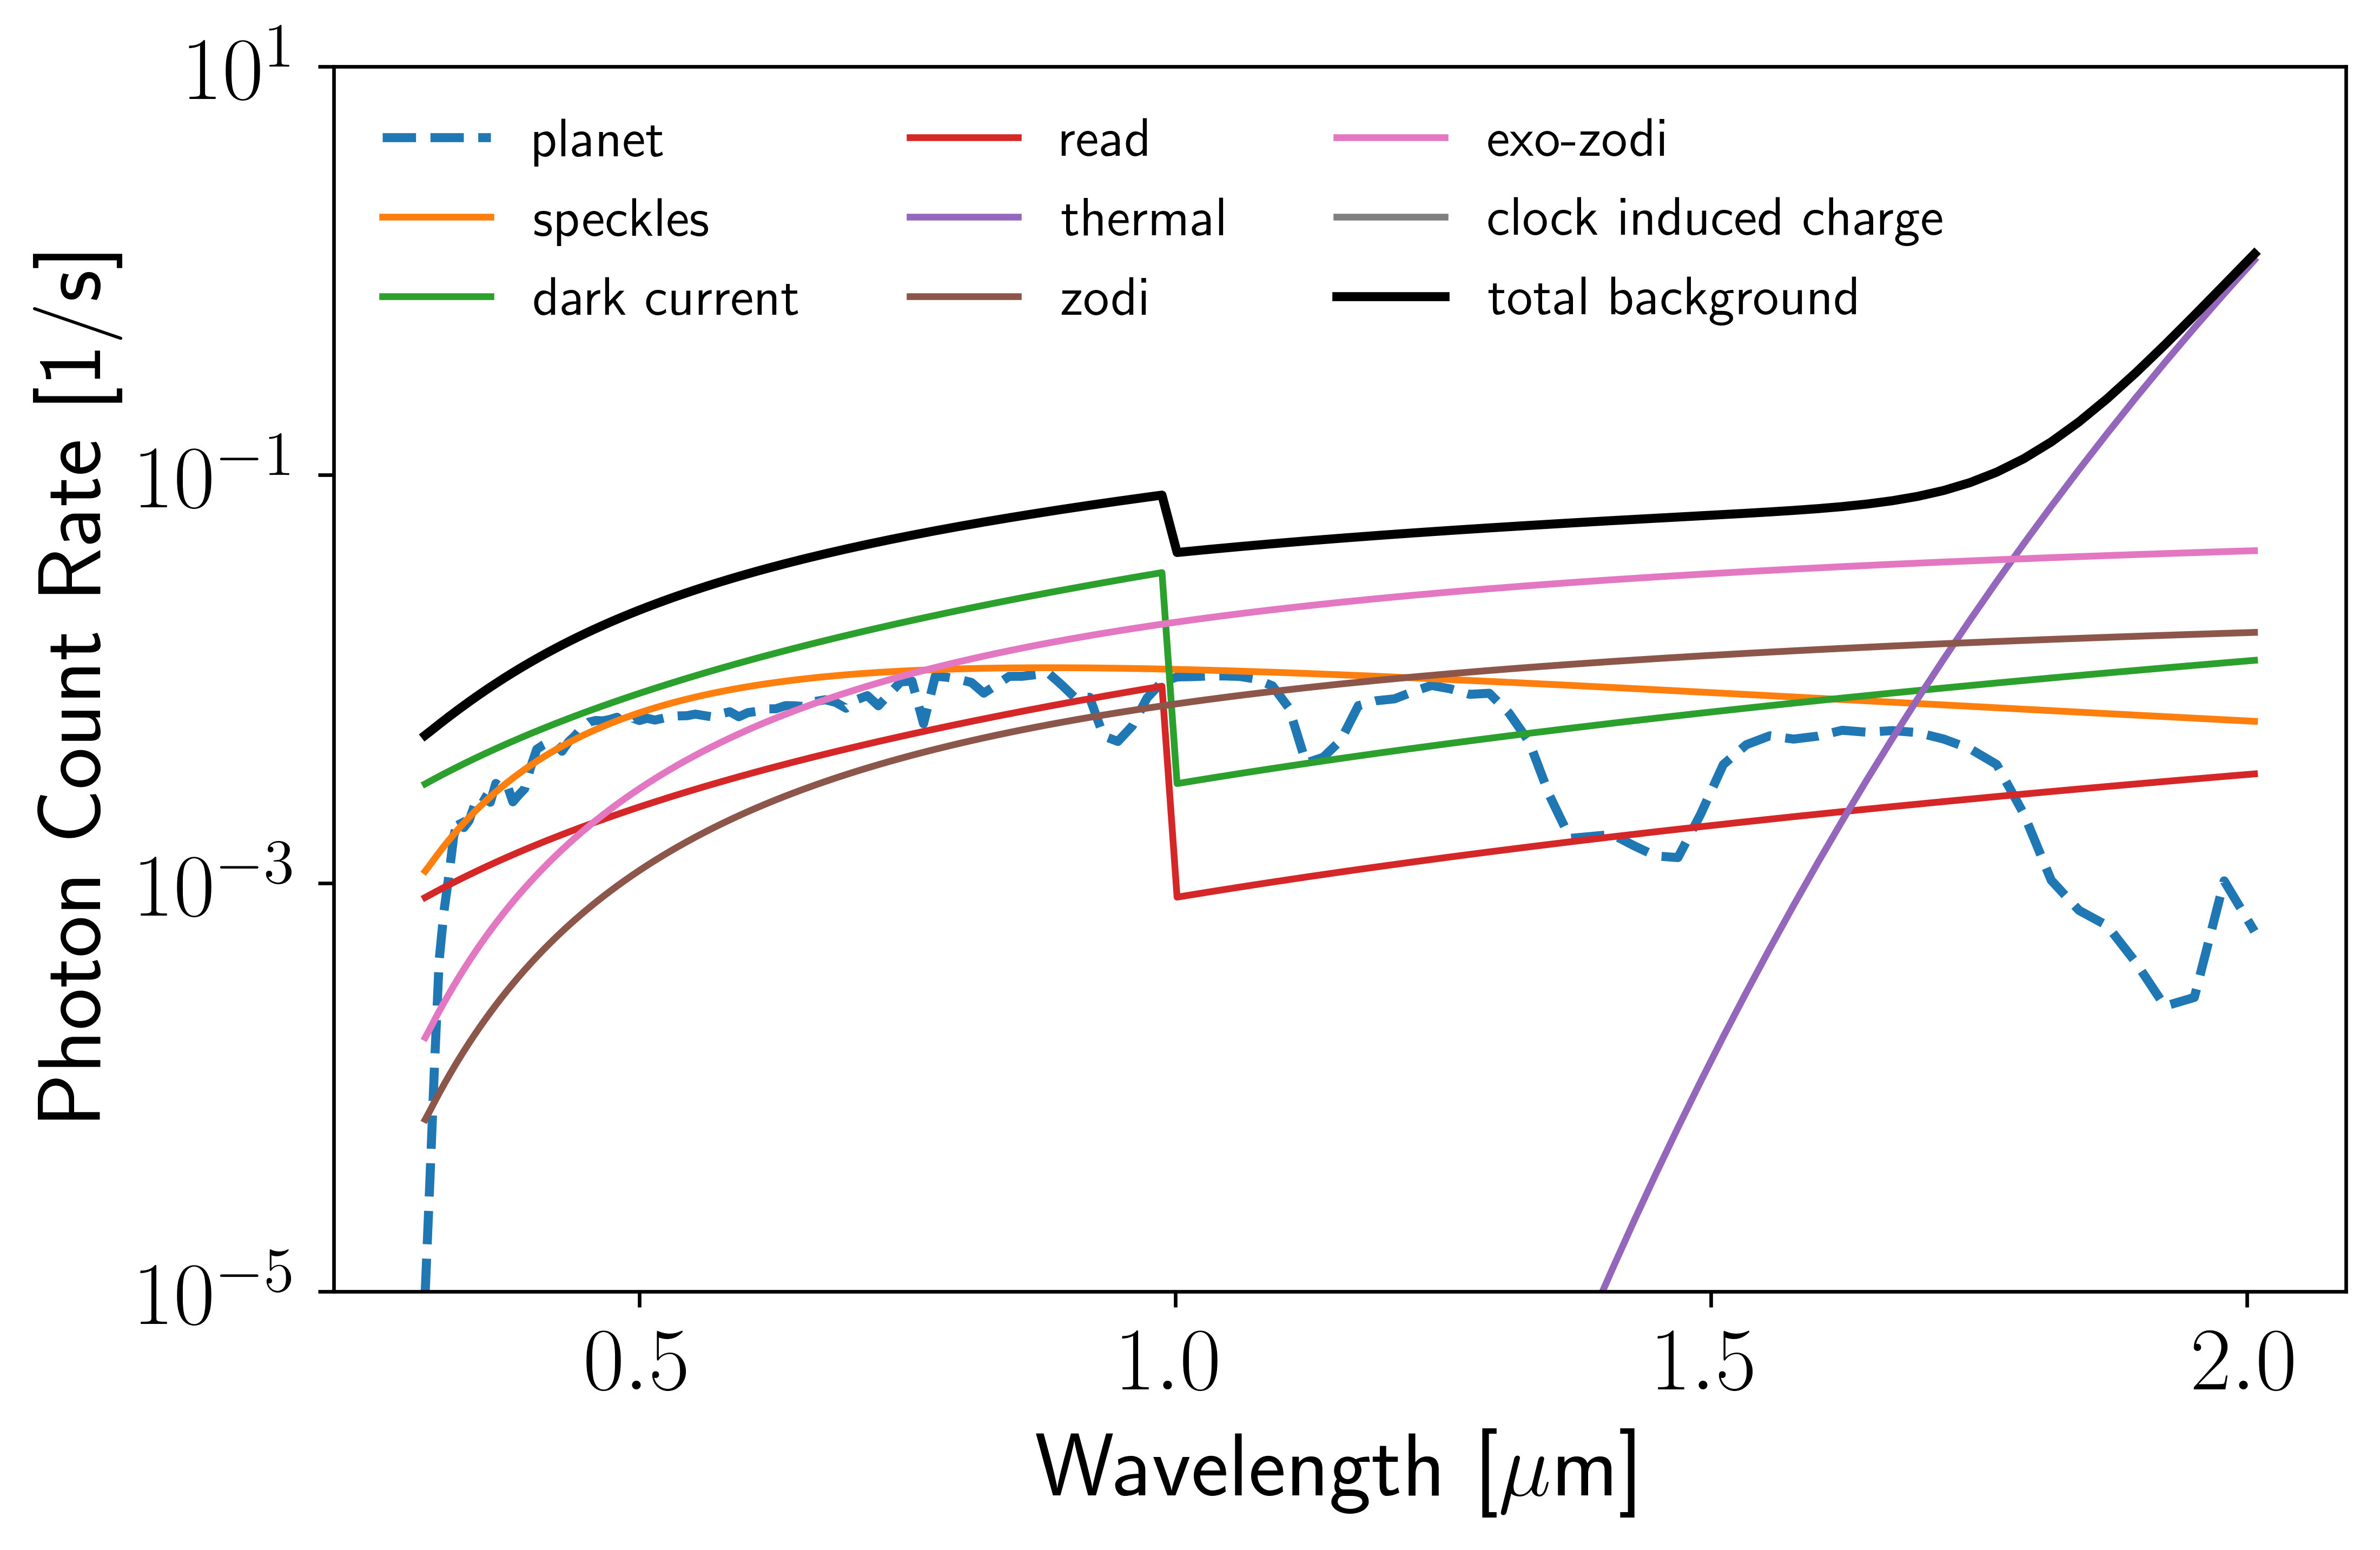

In [12]:
# Make plot
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Photon Count Rate [1/s]")

# Plot the different photon count rates
ax.plot(noise.lam, noise.cp, label = "planet", lw = 2.0, ls = "dashed")
ax.plot(noise.lam, noise.csp, label = "speckles")
ax.plot(noise.lam, noise.cD, label = "dark current")
ax.plot(noise.lam, noise.cR, label = "read")
ax.plot(noise.lam, noise.cth, label = "thermal")
ax.plot(noise.lam, noise.cz, label = "zodi")
ax.plot(noise.lam, noise.cez, label = "exo-zodi")
ax.plot(noise.lam, noise.cc, label = "clock induced charge")
ax.plot(noise.lam, noise.cb, label = "total background", lw = 2.0, color = "k")

# Tweak aesthetics 
ax.set_yscale("log")
ax.set_ylim(bottom = 1e-5, top = 1e1)
ax.legend(fontsize = 12, framealpha = 0.0, ncol = 3);

We can also plot the spectrum with randomly drawn Gaussian noise for our nominal exposure time: 

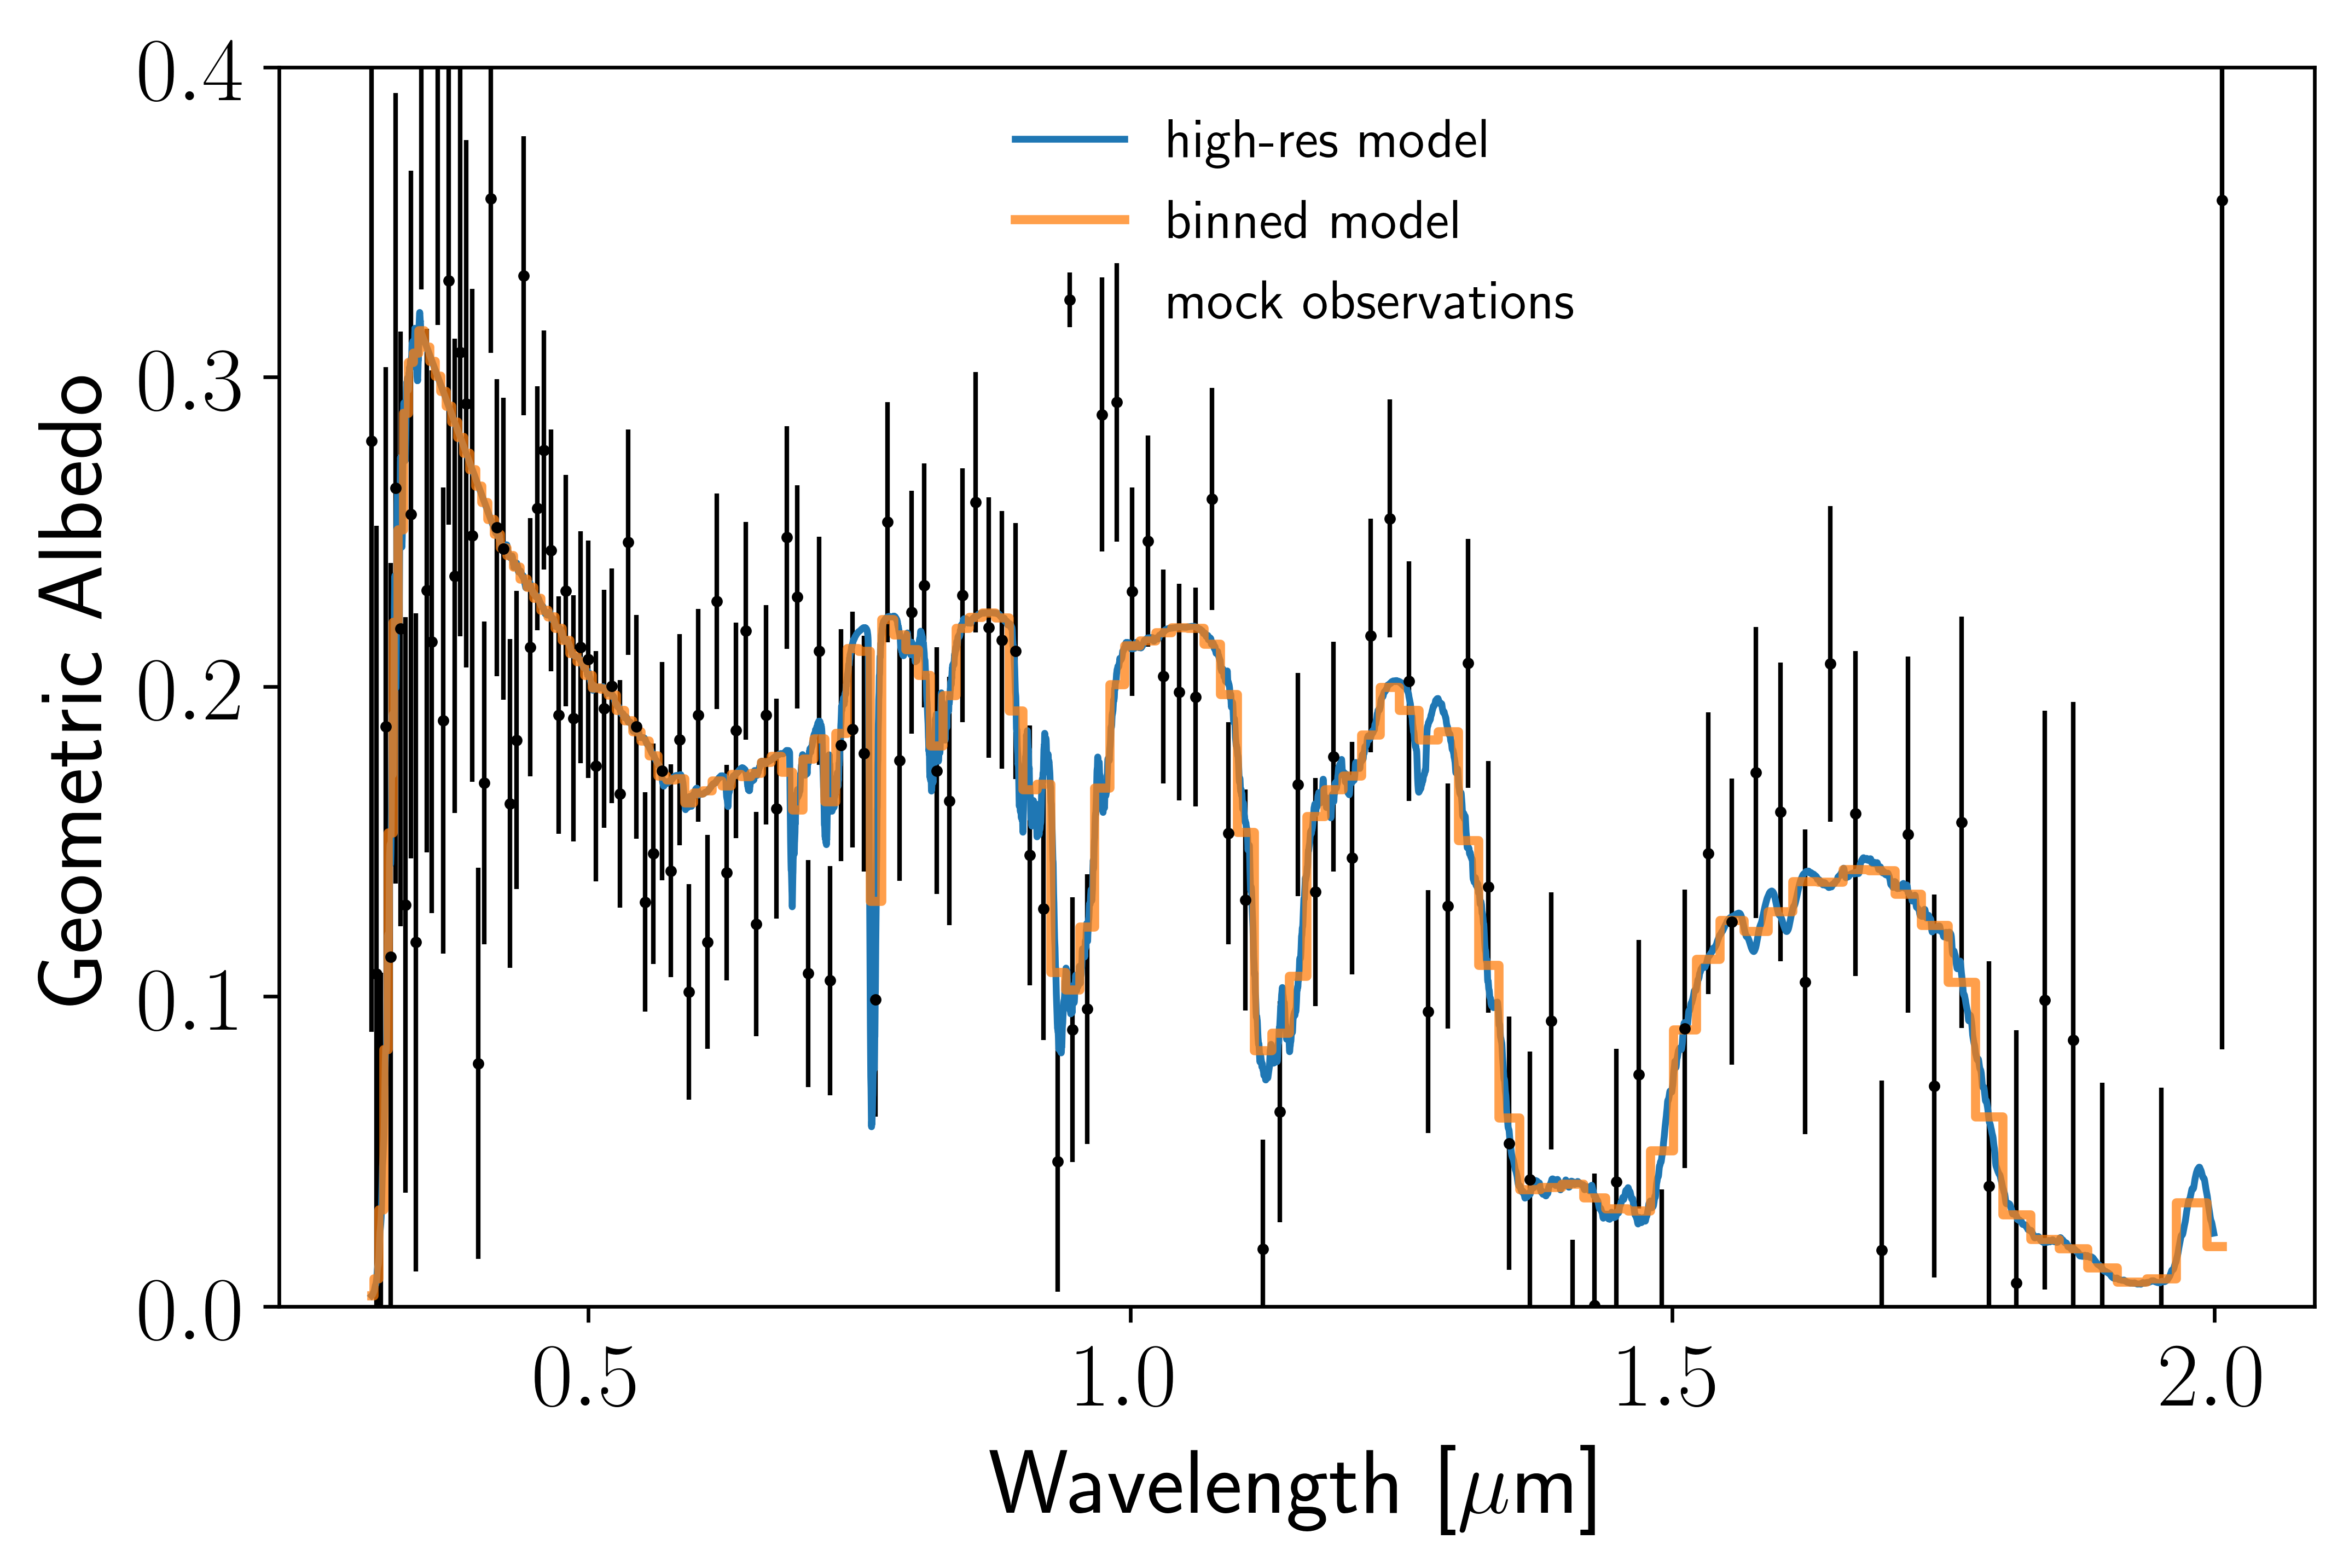

In [13]:
# Make plot
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Geometric Albedo")

# Plot the different photon count rates
ax.plot(lamhr[m], Ahr[m], label = "high-res model")
ax.plot(noise.lam, noise.A, label = "binned model", lw = 2.0, ls = "steps-mid", alpha = 0.75)
ax.errorbar(noise.lam, noise.Aobs, yerr=noise.Asig, fmt = ".", c = "k", ms = 3, lw = 1.0, label = "mock observations")

# Tweak aesthetics 
ax.set_ylim(bottom = 0.0, top = 0.4)
ax.legend(fontsize = 12, framealpha = 0.0);

A version of the above plot can be made using `noise.plot_spectrum()`, but it is not used here for model clarity in this tutorial. 

The above plot gives us a quick look at the data quality that we might expect for an observation using the telescope and system setup. These data can be saved and used in retrieval tests to see if the true underlying atmospheric structure of the Earth can be extracted.  

It's also useful to look at the signal-to-noise (S/N) ratio in each spectral element to see what wavelengths we are getting the highest S/N. We can access the wavelength dependent S/N for our selected exposure time via `noise.SNRt`. For example, 

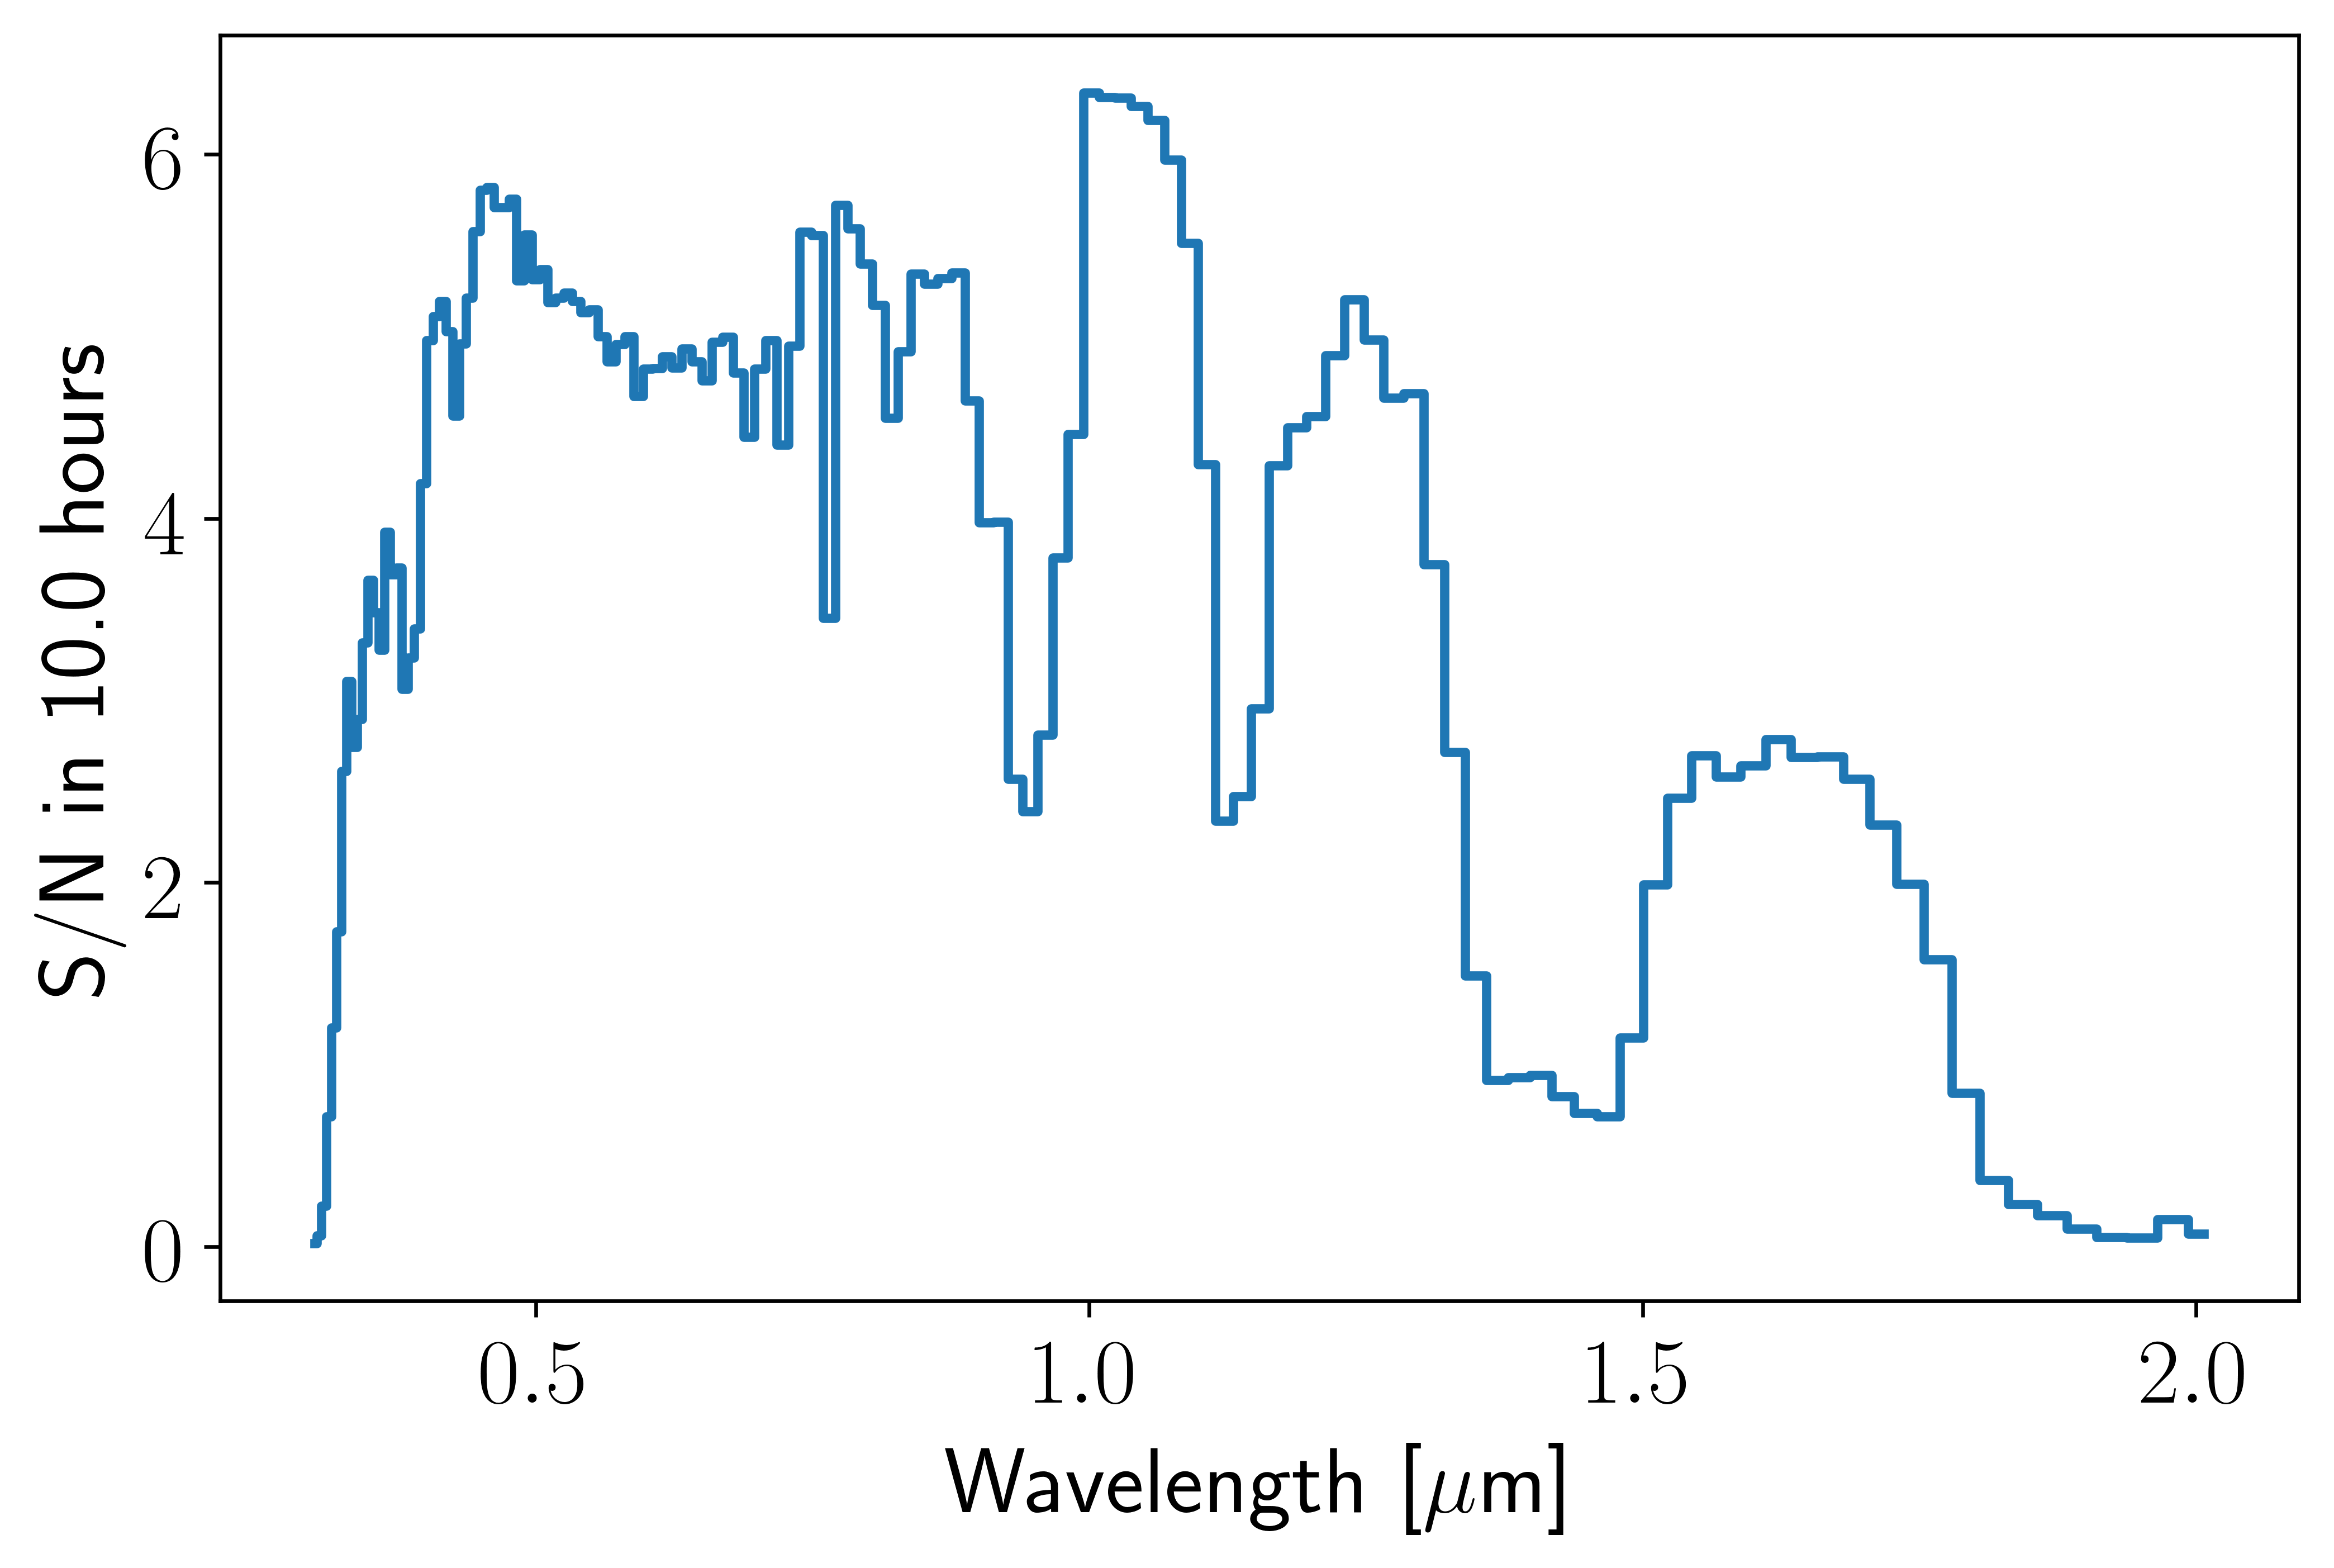

In [14]:
# Make plot
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("S/N in %.1f hours" %noise.wantsnr)

# Plot the different photon count rates
ax.plot(noise.lam, noise.SNRt, lw = 2.0, ls = "steps-mid");

A version of the above plot can be made using `noise.plot_SNR()`.

We can see that the S/N has the same general shape as the stellar SED. We are, after all, observing stellar light reflected off a planet. As a result, the S/N is the highest where the Sun outputs the most photons: around 500 nm. But the S/N is not just the stellar SED, it is the stellar SED *convolved with the planet's reflectivity*. So we get lower S/N in the bottom of molecular absorption bands and higher S/N in the continuum between the bands. The peak in S/N near 0.75 µm is due to the increase in albedo of the Earth's surface (particularly land and vegetation) at that wavelength compared to shorter wavelengths where the Sun emits more photons. 

Finally, let's take a look at the exposure time necessary to achieve a given signal-to-noise ratio (`wantsnr`). This calculated quantity can be accessed via `noise.DtSNR`. For example,  

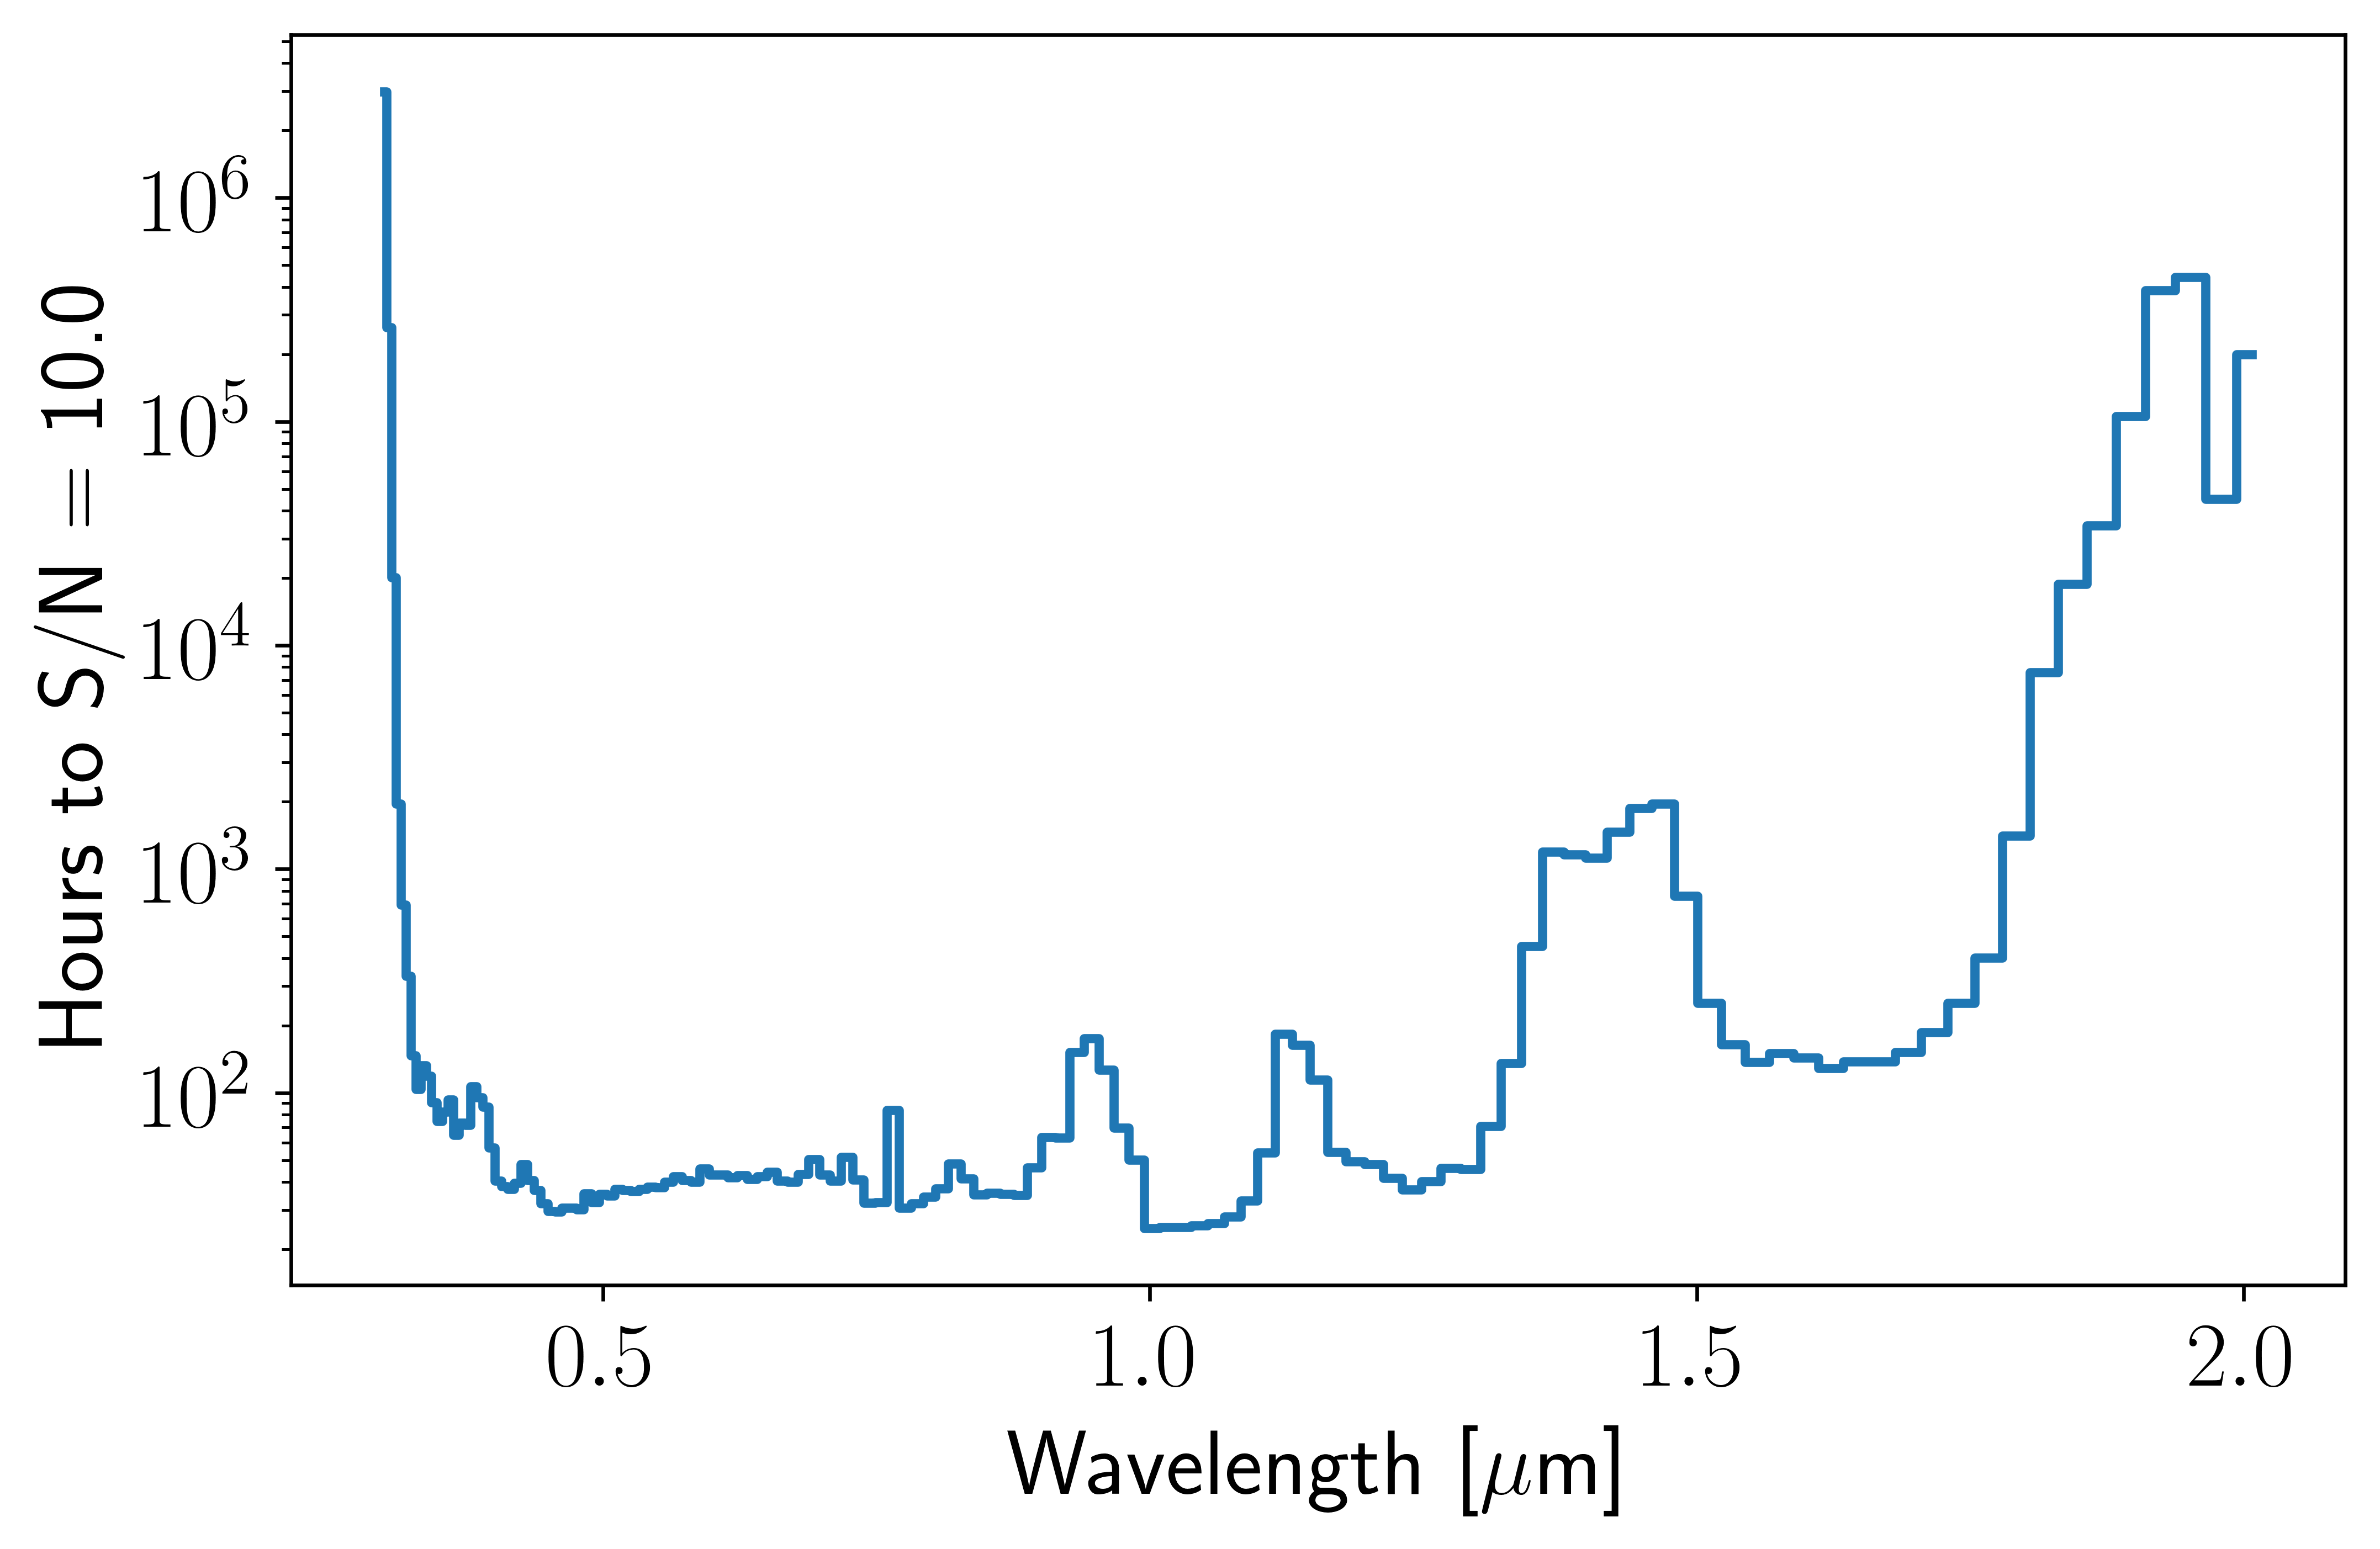

In [15]:
# Make plot
fig, ax = plt.subplots()
ax.set_xlabel("Wavelength [$\mu$m]")
ax.set_ylabel("Hours to S/N = %.1f" %noise.texp)

# Plot the different photon count rates
ax.plot(noise.lam, noise.DtSNR, lw = 2.0, ls = "steps-mid")

# Tweak aesthetics 
ax.set_yscale("log");

A version of the above plot can be made using `noise.plot_time_to_wantsnr()`. 

The exposure time in each spectral element is inversely proportional to the S/N squared, $t_{\text{exp}} \propto (\text{S/N})^{-2}$, so this plot is inverted compared to the last one. Here we see that ridiculously infeasible exposure times are required to achieve high S/N at the wavelengths where fewer photons are reflected off the planet. Of course, this is all assuming that the exoplanet we are looking at *is* Earth. This is an extremely useful benchmark calculation to make (let's make sure we build a telescope capable of studying an exact exo-Earth), but as we see in this example, the spectrum, exposure time, and S/N are all quite dependent on the nature of the exoplanet, which we won't know *a priori*. So now you can use this model with your own simulated exoplanet spectra to see what a future telescope can do for you!  